### Delivery Duration Prediction_ DoorDash


#### Content
This task involves building a model to predict the estimated time taken for a delivery when a consumer places an order on DoorDash. The accuracy of this prediction is crucial for ensuring a positive consumer experience. Therefore, it is important to develop a reliable model that can help DoorDash estimate delivery times accurately. Additionally, you will analyze the model's performance and answer some related questions.

NB: for a given delivery you must predict the total delivery duration seconds , i.e., the time taken from


#### Feature description

- market_id:  geographic market or location where the order was placed
- created_at/ start:  date and time the order submitted by the customers
- actual_delivery_time/ end:  actual time the delivery was completed
- store_id:  unique identifier for the restaurant/store that fulfilled the order
- store_primary_category:  main category or cuisine type of the restaurant or store
- order_protocol:  order fulfillment method or protocol used by the restaurant or store
- total_items:  total number of items ordered
- subtotal:  total cost of the order before any fees or taxes
- num_distinct_items:  number of distinct or unique items ordered
- min_item_price:  price of the cheapest item in the order
- max_item_price:  price of the most expensive item in the order
- total_onshift_dashers:  total number of delivery drivers who were on shift at the time the order
- total_busy_dashers: number of delivery drivers who were currently busy with other orders when the order
- total_outstanding_orders:  total number of orders that were still outstanding and waiting to be delivered at the time the order
- estimated_order_place_duration:  estimated time it will take the restaurant or store to prepare the order
- estimated_store_to_consumer_driving_duration:  estimated time it will take the delivery driver to travel from the restaurant or store to the customer's location to deliver the order

#### Packages and Datasets

In [125]:
## import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime as dt
from datetime import timedelta as td
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer 
from sklearn.impute import KNNImputer
from matplotlib import cm
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

In [127]:
## get the the datasets 
def get_doordash(file_name ='DoorDash_data.csv'):
    df = pd.read_csv(file_name)
    return df
df = get_doordash() 
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


#### Eploratory Data Analysis (EDA)

##### Data quality
    This involves checking for missing values, outliers, incorrect data types, and data inconsistencies

In [128]:
# Check data types
print(df.info()) ## Checking for incorrect data types


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [129]:
df.describe()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
count,196441.000000,197428.000000,196433.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000
mean,2.978706,3530.510272,2.882352,3.196391,2682.331402,2.670791,686.218470,1159.588630,44.808093,41.739747,58.050065,308.560179,545.358935
std,1.524867,2053.496711,1.503771,2.666546,1823.093688,1.630255,522.038648,558.411377,34.526783,32.145733,52.661830,90.139653,219.352902
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000
25%,2.000000,1686.000000,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000
50%,3.000000,3592.000000,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000
75%,4.000000,5299.000000,4.000000,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000
max,6.000000,6987.000000,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000


-  what is the negative value in the min values

market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64


<Axes: >

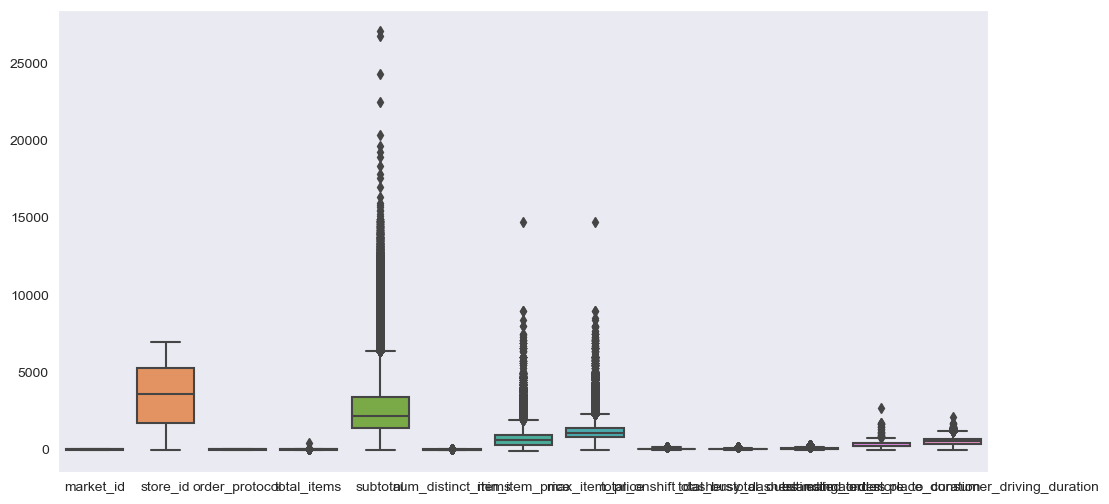

In [130]:
# Check for missing values
print(df.isnull().sum())

# Visualize boxplots for each column
figure=  plt.figure(figsize= (12, 6))
sns.set_style('dark')
sns.boxplot(data=df) ## Checking for outliers


In [131]:
# Check for inconsistencies
inconsistencies = []
for col in df.columns:
    if df[col].nunique() < 2:
        inconsistencies.append(col) ## Checking for data inconsistencies
print('Inconcistent feature in the dataset:', inconsistencies)   

Inconcistent feature in the dataset: []


#
    Handling missing values

In [132]:
## get the colums with a missing values in numerical data:
df_na = df[[ 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'order_protocol', 'estimated_store_to_consumer_driving_duration' ]]

# Create KNN imputer
imputer = KNNImputer(n_neighbors=5)

# Impute missing values
imputed_data = pd.DataFrame(imputer.fit_transform(df_na), columns=df_na.columns)

In [133]:
## mode avergae uses while we use categorical data:

store_id_unique = df["store_id"].unique().tolist()
store_id_and_category = {store_id: df[df.store_id == store_id].store_primary_category.mode()
                             for store_id in store_id_unique}
    
def fill(store_id):
    """Return primary store category from the dictionary""" 
    try:
        return store_id_and_category[store_id].values[0]
    except:
        return np.nan
    
## create a new column in the dataset
df["NaN_free_store_primary_category"] = df.store_id.apply(fill) 

## drop the store id column
df = df.drop('store_primary_category', axis= 1)


In [134]:
### repalacing the old columns with the new ones
df[['total_onshift_dashers', 'total_busy_dashers', 
'total_outstanding_orders', 'order_protocol', 'estimated_store_to_consumer_driving_duration']] = imputed_data[['total_onshift_dashers','total_busy_dashers', 'total_outstanding_orders', 
                                                                                                                'order_protocol', 'estimated_store_to_consumer_driving_duration' ]]

## drop na values from actual delivery column


print('Total nan values in the dataset:\n\n', df.isnull().sum())

Total nan values in the dataset:

 market_id                                       987
created_at                                        0
actual_delivery_time                              7
store_id                                          0
order_protocol                                    0
total_items                                       0
subtotal                                          0
num_distinct_items                                0
min_item_price                                    0
max_item_price                                    0
total_onshift_dashers                             0
total_busy_dashers                                0
total_outstanding_orders                          0
estimated_order_place_duration                    0
estimated_store_to_consumer_driving_duration      0
NaN_free_store_primary_category                 867
dtype: int64


### Data Distribution
    This involves visualizing the data to identify its distribution, skewness, and kurtosis.

In [135]:
df.columns

Index(['market_id', 'created_at', 'actual_delivery_time', 'store_id',
       'order_protocol', 'total_items', 'subtotal', 'num_distinct_items',
       'min_item_price', 'max_item_price', 'total_onshift_dashers',
       'total_busy_dashers', 'total_outstanding_orders',
       'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration',
       'NaN_free_store_primary_category'],
      dtype='object')

In [ ]:

# Create a figure with subplots for each feature
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(12, 8))

# Plot histograms for each feature
sns.histplot(data=df, x='NaN_free_store_primary_category', kde=True, ax=axs[0, 0], bins = 50)
sns.histplot(data=df, x='order_protocol', kde=True, ax=axs[0, 1])
sns.histplot(data=df, x='feature3', kde=True, ax=axs[0, 2])
sns.histplot(data=df, x='feature4', kde=True, ax=axs[1, 0])
sns.histplot(data=df, x='feature5', kde=True, ax=axs[1, 1])
sns.histplot(data=df, x='feature6', kde=True, ax=axs[1, 2])

plt.show()

### Data Transformation
        Adding new features

In [190]:
df2 = df.copy()

In [191]:
## change cols to datetime
def to_date(col):
    col = pd.to_datetime(col)
    return col
df2[['created_at', 'actual_delivery_time']]  = df2[['created_at', 'actual_delivery_time']].apply(lambda x:to_date(x))

In [192]:
## Get the target variable
df2['actual_delivery_duration'] = df2['actual_delivery_time']-df2['created_at']
df2['actual_delivery_duration'] = df2['actual_delivery_duration'].dt.seconds

# new features/ predictive variable
df2['busy_to_onshift_dasher'] = round(df2['total_busy_dashers']/df2['total_onshift_dashers'], 2) ## getting the ratio of busy dasher over the total
df2["avg_price_per_item"] = df2["subtotal"] / df2["total_items"]                                  ## give the total price (before tax) of as item
df2['range_of_prices'] = df2['max_item_price'] - df2['min_item_price']                             ### price range 

In [193]:
df2 = df2.drop(columns=["total_onshift_dashers", "total_busy_dashers", "subtotal", "max_item_price", "min_item_price"])
df2.head()

,market_id,created_at,actual_delivery_time,store_id,order_protocol,total_items,num_distinct_items,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,NaN_free_store_primary_category,actual_delivery_duration,busy_to_onshift_dasher,avg_price_per_item,range_of_prices
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,1.0,4,4,21.0,446,861.0,american,3779.0,0.42,860.25,682
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,2.0,1,1,2.0,446,690.0,indian,4024.0,2.00,1900.00,0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,1.0,1,1,0.0,446,690.0,indian,1781.0,0.00,1900.00,0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,1.0,6,5,2.0,446,289.0,indian,3075.0,1.00,1150.00,1200
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,1.0,3,3,9.0,446,650.0,indian,2390.0,1.00,1300.00,500


In [194]:
## Add Dummies to the market_id
market_dum_id = pd.get_dummies(df2['market_id'], prefix = ('market_id_'))

### Add dummies to the order category
order_dummies = pd.get_dummies(df2['order_protocol'], prefix = ('order_protocol_'))

## Add dummies to the store category
store_dummies = pd.get_dummies(df2["NaN_free_store_primary_category"], prefix = 'category_')

In [195]:
df2.columns

Index(['market_id', 'created_at', 'actual_delivery_time', 'store_id',
       'order_protocol', 'total_items', 'num_distinct_items',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration',
       'NaN_free_store_primary_category', 'actual_delivery_duration',
       'busy_to_onshift_dasher', 'avg_price_per_item', 'range_of_prices'],
      dtype='object')

In [196]:
## Merge the dummies to the main datasets inclusing the target variable
dff = df2.drop(columns = ['market_id', 'created_at', 'actual_delivery_time', 'store_id','order_protocol', 'NaN_free_store_primary_category'])

df_final = pd.concat([dff, market_dum_id, order_dummies, store_dummies], axis = 1)

***

### Data correlations
    This involves identifying relationships between variables in the data and analyzing their strength and direction.

<Axes: >

<Figure size 300x300 with 0 Axes>

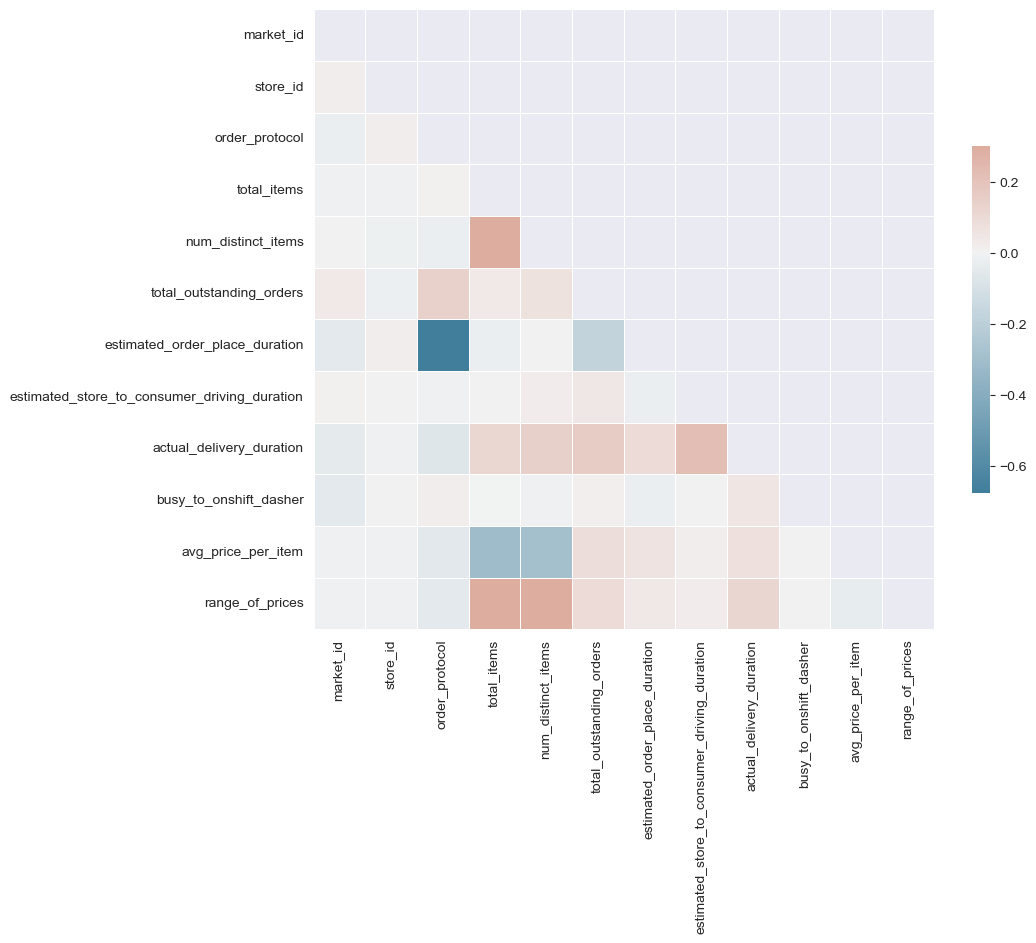

In [199]:
### the dataset before transformation
corr = df2.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))  # helps get the Main Diagonal elements

# Set up the matplotlib figure
fig = plt.figure(figsize = (3,3))
fig, ax = plt.subplots(figsize=(10, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

***


### Feature importance
        This involves identifying the most important features in the data and their impact on the target variable.

##### Reduce Redundant and Collinear Features

<Axes: >

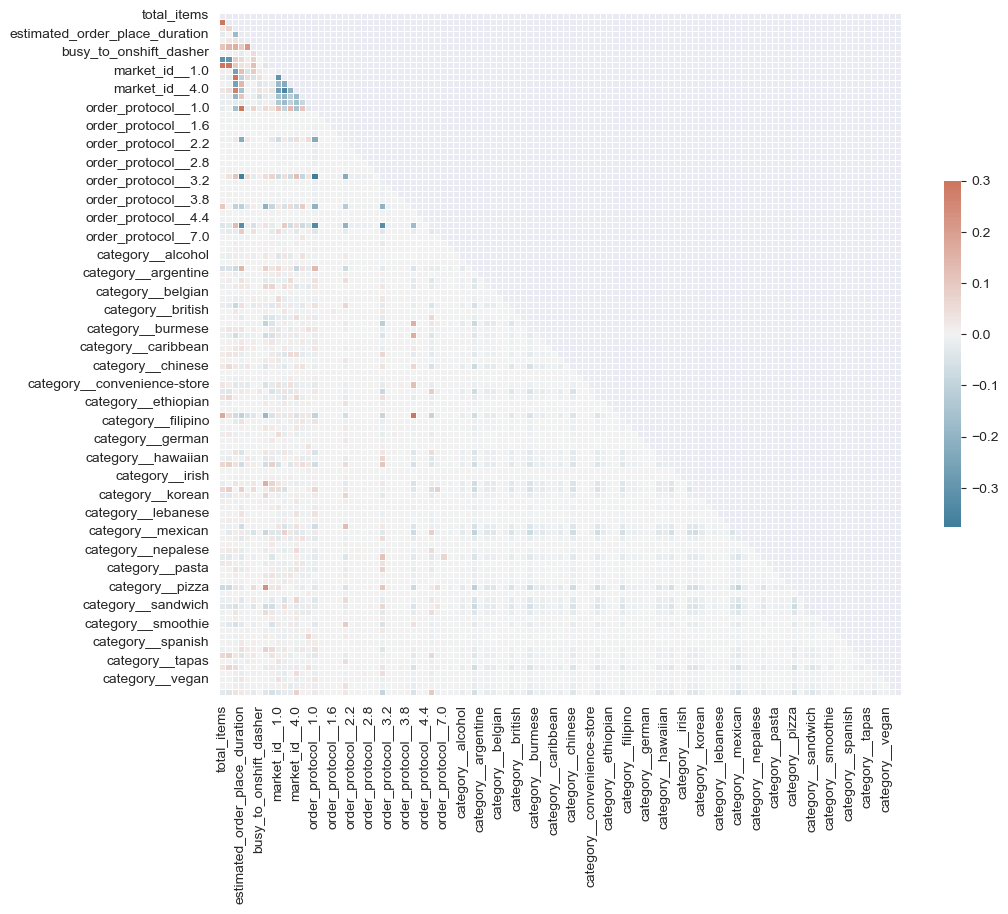

In [200]:
# it could take some time to run this cell since we are calculating correlation matrix in a dimesion of (100x100)

# Generate a mask for the upper triangle
corr = df_final.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))  # helps get the Main Diagonal elements

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [201]:
# check infinity values with using numpy isfinite() function
np.where(np.any(~np.isfinite(df_final),axis=0) == True) ## the non infinite values

# replace inf values with nan to drop all nans
df_final.replace([np.inf, -np.inf], np.nan, inplace=True)

# drop NaN
df_final.dropna(how ='all', inplace=True)
df_final.shape

(197428, 111)

In [202]:
## Get diagonal and lower triangular pairs of the matrix
def get_redundant_pairs(df):  
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

In [203]:
## Sort correlations in the descending order and return n highest results
def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations\n")
print(get_top_abs_correlations(df_final, 20))

Top Absolute Correlations
estimated_order_place_duration  order_protocol__1.0    0.895596
total_items                     num_distinct_items     0.763912
num_distinct_items              range_of_prices        0.499245
order_protocol__4.0             category__fast         0.496128
order_protocol__1.0             order_protocol__3.0    0.376742
estimated_order_place_duration  order_protocol__3.0    0.368259
market_id__2.0                  market_id__4.0         0.350511
total_items                     range_of_prices        0.334691
order_protocol__1.0             order_protocol__5.0    0.333046
order_protocol__3.0             order_protocol__5.0    0.327162
estimated_order_place_duration  order_protocol__5.0    0.325000
total_items                     avg_price_per_item     0.315521
market_id__1.0                  market_id__2.0         0.303789
total_outstanding_orders        market_id__2.0         0.296189
num_distinct_items              avg_price_per_item     0.293897
market_id__1.0

- From the correlation : we can see that there high correlation in the top of the list columns > need to drop them

#
     Drop market_id_dummies

In [206]:
df2.columns

Index(['market_id', 'created_at', 'actual_delivery_time', 'store_id',
       'order_protocol', 'total_items', 'num_distinct_items',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration',
       'NaN_free_store_primary_category', 'actual_delivery_duration',
       'busy_to_onshift_dasher', 'avg_price_per_item', 'range_of_prices'],
      dtype='object')

In [213]:
# drop created_at, market_id, store_id, store_primary_category, actual_delivery_time, order_protocol
df_final1 = df2.drop(columns = ["created_at", "market_id", "store_id", "actual_delivery_time", 
                                        "NaN_free_store_primary_category", "order_protocol"])
# don't concat market id
df_final1 = pd.concat([df_final1, order_dummies , store_dummies], axis=1)

# drop highly correlated features
df_final1 = df_final1.drop(columns=["category__irish"])

# align dtype over dataset
df_final1 = df_final1.astype("float32")

# replace inf values with nan to drop all nans
df_final1.replace([np.inf, -np.inf], np.nan, inplace=True)
df_final1.dropna(inplace=True)

In [208]:
print("Top Absolute Correlations\n")
print(get_top_abs_correlations(df_final1, 20))

Top Absolute Correlations
estimated_order_place_duration                order_protocol__1.0         0.896660
total_items                                   num_distinct_items          0.762519
num_distinct_items                            range_of_prices             0.500664
order_protocol__4.0                           category__fast              0.496343
order_protocol__1.0                           order_protocol__3.0         0.376633
estimated_order_place_duration                order_protocol__3.0         0.367458
total_items                                   range_of_prices             0.335427
order_protocol__1.0                           order_protocol__5.0         0.333257
order_protocol__3.0                           order_protocol__5.0         0.329467
estimated_order_place_duration                order_protocol__5.0         0.324580
total_items                                   avg_price_per_item          0.315079
num_distinct_items                            avg_price_per_i

#
        Drop order_protocol_dummies

In [212]:
### Then drop the order protocol dummies as there is a large correlation 
# drop created_at, market_id, store_id, store_primary_category, actual_delivery_time, order_protocol

df_final2 = df2.drop(columns = ["created_at", "market_id", "store_id", "actual_delivery_time", 
                                        "NaN_free_store_primary_category", "order_protocol"])
# don't concat market id
df_final2 = pd.concat([df_final2, store_dummies], axis=1)
# drop highly correlated features
df_final2 = df_final2.drop(columns=["category__irish", "category__indonesian"])
# align dtype over dataset
df_final2 = df_final2.astype("float32")
# replace inf values with nan to drop all nans
df_final2.replace([np.inf, -np.inf], np.nan, inplace=True)
df_final2.dropna(inplace=True)

In [215]:
print("Top Absolute Correlations\n")
print(get_top_abs_correlations(df_final2, 20))

Top Absolute Correlations

total_items                                   num_distinct_items                0.762519
num_distinct_items                            range_of_prices                   0.500664
total_items                                   range_of_prices                   0.335427
                                              avg_price_per_item                0.315079
num_distinct_items                            avg_price_per_item                0.293883
avg_price_per_item                            category__pizza                   0.232446
estimated_store_to_consumer_driving_duration  actual_delivery_duration          0.221315
avg_price_per_item                            category__fast                    0.180453
total_items                                   category__fast                    0.178247
total_outstanding_orders                      actual_delivery_duration          0.176015
                                              estimated_order_place_duration    0.1

-  Variance Inflation Factore (VIF) determines the strength of the correlation between the independent variables.

In [ ]:
## Compute VIF score using variance_inflation_factor() function
def compute_vif(features):
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(df_final2[features].values, i) for i in range(len(features))] ## or you can use len(features)
    return vif_data.sort_values(by=['VIF']).reset_index(drop=True)

In [ ]:
# apply VIF computation to all predicting columns: drop the target variable :
features = df_final2.drop(columns=["actual_delivery_duration"]).columns.to_list()
vif_data = compute_vif(features)
vif_data

,feature,VIF
0,category__alcohol-plus-food,1.000224
1,category__chocolate,1.000372
2,category__belgian,1.000462
3,category__russian,1.002048
4,category__gluten-free,1.002623
...,...,...
75,total_items,6.109966
76,busy_to_onshift_dasher,6.350498
77,estimated_store_to_consumer_driving_duration,7.186160
78,num_distinct_items,10.919325


In [ ]:
## Drop the columns with the higher VIF score: when it is greater that 20

multicollinearity = True
while multicollinearity:
    highest_vif_feature = vif_data['feature'].values.tolist()[-1]
    print("I will remove", highest_vif_feature)
    features.remove(highest_vif_feature)
    vif_data = compute_vif(features)
    multicollinearity = False if len(vif_data[vif_data.VIF > 20]) == 0 else True

selected_features = vif_data['feature'].values.tolist()
vif_data 

I will remove estimated_order_place_duration


,feature,VIF
0,category__alcohol-plus-food,1.000187
1,category__belgian,1.000202
2,category__chocolate,1.000251
3,category__russian,1.001379
4,category__gluten-free,1.001444
...,...,...
74,avg_price_per_item,5.989006
75,total_items,6.109840
76,busy_to_onshift_dasher,6.349345
77,estimated_store_to_consumer_driving_duration,7.184786


###  Data dimensionality
         This involves analyzing the number of features and their relevance in the analysis/ feature selection

In [ ]:
# selected features are selected in multicollinearity check part
X = df_final2[selected_features]
y = df_final2["actual_delivery_duration"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

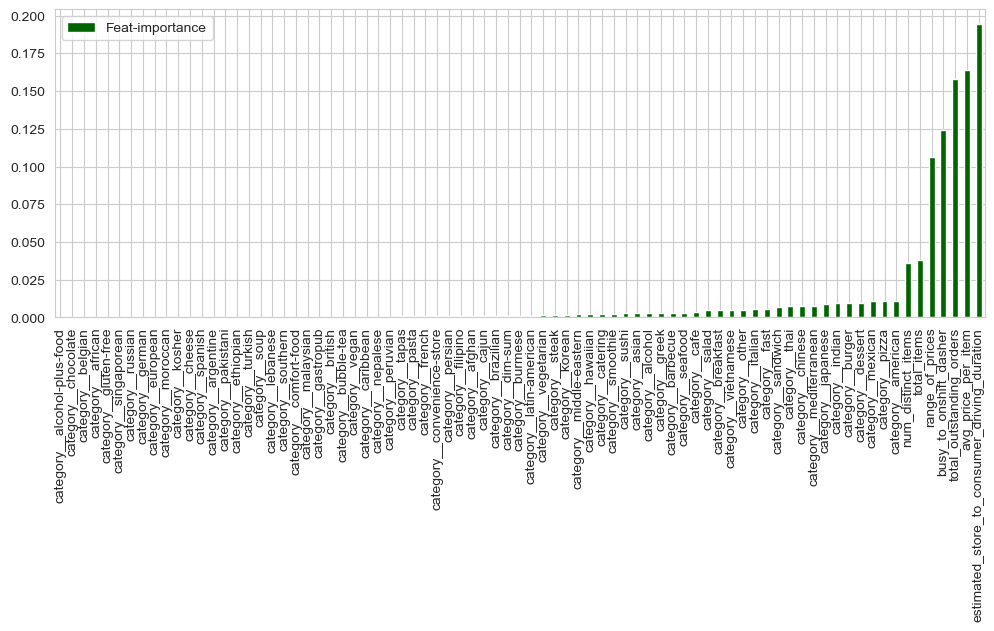

In [ ]:
feature_names = [f"feature {i}" for i in range((X.shape[1]))] ## there are many things that we 
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)
feat_dic = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, forest.feature_importances_):
    feat_dic[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feat_dic, orient='index').rename(columns={0: 'Feat-importance'})
importances.sort_values(by='Feat-importance').plot(kind='bar', rot=90, figsize=(12,4), color = 'darkgreen')
plt.show()

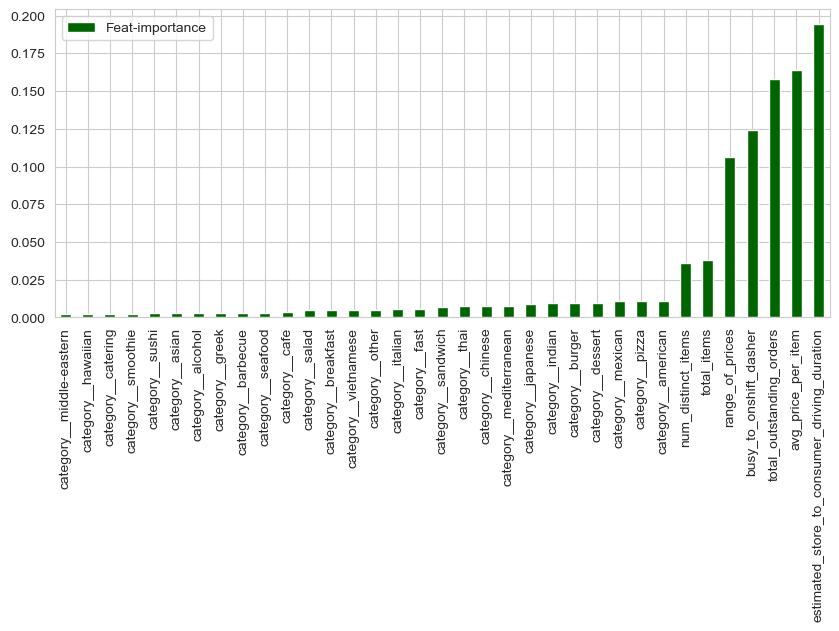

In [ ]:
# check the most important ones
importances.sort_values(by='Feat-importance')[-35:].plot( kind='bar', rot=90, figsize=(10,4) ,color = 'darkgreen')
plt.show()

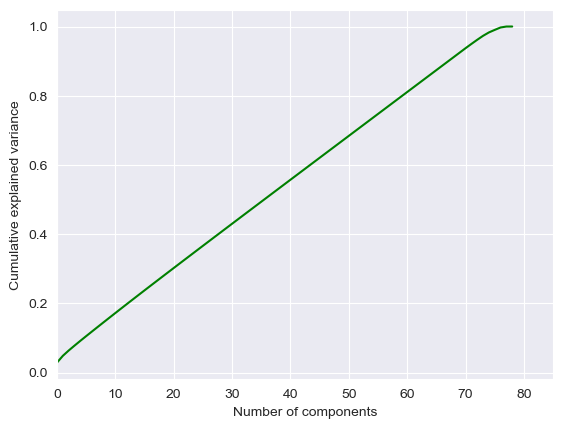

In [ ]:
# apply PCA to see feature contributions
X_Train = X_train.values
X_Train = np.asarray(X_Train)

# Finding normalised array of X_Train
X_std=StandardScaler().fit_transform(X_Train)
pca = PCA().fit(X_std)
sns.set_style('darkgrid')
plt.plot(np.cumsum(pca.explained_variance_ratio_), color = 'green')
plt.xlim(0,85)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

- PCA shows that we need to use at least 60 representative features to explain 80% of the dataset, which makes the PCA transformation useless since we already have 80 and could select the most important ones based on feature importance. However, if PCA would tell us it can explain the majority of variance with around 10 features - high reduction - we would continue with it.

### Scaling

In [ ]:
## Apply the selected scaler to features and target variables
def scale(scaler, X, y):
    X_scaler = scaler
    X_scaler.fit(X = X , y = y)
    X_scaled = X_scaler.transform(X)
    y_scaler = scaler
    y_scaler.fit(y.values.reshape(-1, 1))
    y_scaled = y_scaler.transform(y.values.reshape(-1, 1))
    
    return X_scaled, y_scaled, X_scaler, y_scaler

In [ ]:
### scaling out predictive and target variable
X_scaled, y_scaled, X_scaler, y_scaler = scale(MinMaxScaler(), X, y)

# train-test split after scaling
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42)

### Inverse Transform for Metric Comparison


- Since we applied a scaler to training data, the predictions for test data will also be scaled. And to see the error in terms of seconds, we need to apply the inverse transformation. We will use Root Mean Squared Error to measure error. We could also use Mean Squared Error or Mean Absolute Error. We gave our decision based on the sensitivity of RMSE for high error terms. In out perception we are assuming, the consumer patience with delaying delivery could decrease exponentially with time

In [ ]:
def rmse_with_inv_transf(scaler, y_test, y_pred_scaled, model_name):
    ### convert the scaled error to real error by inverse_transforming 
    y_predict = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)) 
    ## get the rmse without squaring
    rmse_error = mean_squared_error(y_test, y_predict[:, 0], squared = False)
    print(f' Error: "''{}'.format(rmse_error)+" in " + model_name)
    return rmse_error, y_predict

### Machine Learning

In [ ]:
# create a generic function: that works with multiple ML models
def make_regression(X_train, y_train, X_test, y_test, model, model_name, all_good = False):
    model.fit(X_train, y_train)
    y_predict = model.predict(X_train)
    train_err = mean_squared_error(y_train, y_predict, squared = False)
    y_predict = model.predict(X_test)
    test_err =  mean_squared_error(y_test, y_predict, squared = False)
    if all_good:
        print("Train error =" '{}'.format(train_err) + " in " + model_name)
        print("Test error ="'{}'.format(test_err) + " in " + model_name)
    trained_model = model
    
    return trained_model, y_predict, train_err, test_err


In [ ]:
#from xgboost import XGBregressor
#from lightgbm import LGBMregressor
#from sklearn.neutral_networking import MLPRegressor
from sklearn import tree
from sklearn import neighbors
from sklearn import linear_model

In [ ]:
pred_dict = {
    "Regression_model":[],
    "Feature_set":[],
    "Scaler_name":[],
    "RMSE":[]
}

regression_models = {
    "Ridge": linear_model.Ridge(),
    "Decision_tree": tree.DecisionTreeRegressor(max_depth = 6),
    "Random_forest": RandomForestRegressor()
}

feature_sets = {
    "whole_set":X.columns.tolist(),
    "selected_feat_40":importances.sort_values(by = 'Feat-importance')[-40:].index.tolist(),
    "selected_feat_20":importances.sort_values(by = 'Feat-importance')[-20:].index.tolist()
}

scaler = {
    "Standard_scalar": StandardScaler(),
    "MinMax_scalar": MinMaxScaler(),
    "No_scaling" : None
}

In [ ]:
### exploring the errors in each model
for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scaler.keys():
        print(f"------Scaled with {scaler_name} ------included features are {feature_set_name}")
        for model_name in regression_models.keys():
            if scaler_name == 'No_scaling':
                X = df_final2[feature_set]
                y = df_final2['actual_delivery_duration']
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
                make_regression(X_train, y_train, X_test, y_test, regression_models[model_name], model_name, all_good =True)
            else:
            
                X_scaled, y_scaled, X_scaler, y_scaler = scale(scaler[scaler_name], X[feature_set], y)
                X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
                X_scaled, y_scaled, test_size=0.2, random_state=42)
                _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, all_good=False)
                rmse_error, y_predict = rmse_with_inv_transf(y_scaler, y_test, y_predict_scaled, model_name)
                          
           
                
            pred_dict["Regression_model"].append(model_name)
            pred_dict["Feature_set"].append(feature_set_name)
            pred_dict["Scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)

------Scaled with Standard_scalar ------included features are whole_set
 Error: "1147.12255859375 in Ridge
 Error: "1147.1599099176187 in Decision_tree
 Error: "1146.822436245734 in Random_forest
------Scaled with MinMax_scalar ------included features are whole_set
 Error: "1147.206298828125 in Ridge
 Error: "1147.1599096656478 in Decision_tree
 Error: "1146.855311703357 in Random_forest
------Scaled with No_scaling ------included features are whole_set
Train error =1078.8773193359375 in Ridge
Test error =1147.114990234375 in Ridge
Train error =1073.092903542184 in Decision_tree
Test error =1147.1599100050832 in Decision_tree
Train error =401.45285794631013 in Random_forest
Test error =1143.6449954411228 in Random_forest
------Scaled with Standard_scalar ------included features are selected_feat_40
 Error: "1147.955322265625 in Ridge
 Error: "1147.0636020224683 in Decision_tree
 Error: "1143.7878935081103 in Random_forest
------Scaled with MinMax_scalar ------included features are sele

### Overvew of our Models

In [ ]:
### over view how models predicted
pred_df = pd.DataFrame(pred_dict)
pred_df.head()

,Regression_model,Feature_set,Scaler_name,RMSE
0,Ridge,whole_set,Standard_scalar,1147.122559
1,Decision_tree,whole_set,Standard_scalar,1147.159910
2,Random_forest,whole_set,Standard_scalar,1146.822436
3,Ridge,whole_set,MinMax_scalar,1147.206299
4,Decision_tree,whole_set,MinMax_scalar,1147.159910


<AxesSubplot:>

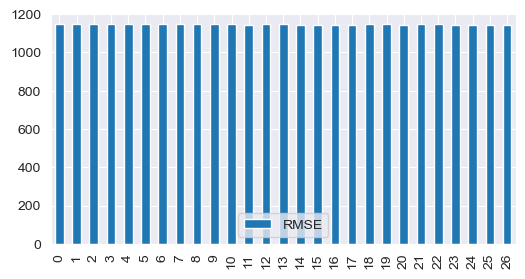

In [ ]:
pred_df.plot(kind='bar', figsize=(6,3))

#### Findings

- It seems we have high errors through all models
- Models inform us to not scale affects the performance.
- We could pick one of the scalers and continue since it doesn't affect the performance much. 
- The decrease in training feature size first slightly improves the performance and then marginally made it worse. 
- We choose to use 40 as a final decision. 
- When we examine the model performances, the most significant thing is the error rates. 

In [ ]:
st_s = pred_df[pred_df['Scaler_name'] == 'Standard_scalar']
Feat_40_stan_sc = st_s[st_s['Feature_set'] == 'selected_feat_40']
Feat_40_stan_sc

,Regression_model,Feature_set,Scaler_name,RMSE
9,Ridge,selected_feat_40,Standard_scalar,1147.955322
10,Decision_tree,selected_feat_40,Standard_scalar,1147.063602
11,Random_forest,selected_feat_40,Standard_scalar,1143.787894


- From the findings --> RandomForest got the best result. Then we peoceed with that model

####  Random Forest model

In [ ]:
pred_dict = {
    "Regression_model":[],
    "Feature_set":[],
    "Scaler_name":[],
    "RMSE":[]
}
regression_models = {
    "Random_forest": RandomForestRegressor(),
}
feature_sets = {
    "selected_feat_40":importances.sort_values(by = 'Feat-importance')[-40:].index.tolist(),   
}
scaler = {
    "Standard_scalar": StandardScaler(),
}

In [ ]:
### exploring the errors in each model
for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scaler.keys():
        print(f"------Scaled with {scaler_name} ------included features are {feature_set_name}")
        for model_name in regression_models.keys():
            X = df_final2[feature_set]
            y = df_final2['actual_delivery_duration']
            # to get indices
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices  = X_test.index
            
            # scale
            X_scaled, y_scaled, X_scaler, y_scaler = scale(scaler[scaler_name], X, y)
            
            # apply indexing
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
            _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, all_good=False)
            rmse_error, y_predict = rmse_with_inv_transf(y_scaler, y_test, y_predict_scaled, model_name)
            
            pred_dict["Regression_model"].append(model_name)
            pred_dict["Feature_set"].append(feature_set_name)
            pred_dict["Scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)

------Scaled with Standard_scalar ------included features are selected_feat_40
 Error: "1144.3139314809023 in Random_forest


In [ ]:
y_test = np.array(y_test)
df = pd.DataFrame({'True Labels': y_test, 'Predicted Labels': pd.Series(np.ravel(y_predict))})
df.head()

,True Labels,Predicted Labels
0,2448.0,2440.639996
1,1839.0,3000.350007
2,1927.0,3208.280005
3,2657.0,2042.150000
4,3596.0,2940.540002


### questions:

#### Are there particular restaurant cuisines (store_primary_category) that tend to have longer or shorter delivery times, and why? 

In [ ]:
places = df_new.groupby('NaN_free_store_primary_category')['actual_delivery_duration'].mean().sort_values(ascending = False)
places = places.head(30)


In [ ]:
sns.set_style("whitegrid")
sns.lineplot(y = places.index, x = places.values)